##  In the realm of neural networks, how do you perceive the delicate balance between model complexity, overfitting, and underfitting? Furthermore, could you delve into the strategy you might employ to strike this balance effectively, particularly when confronted with resource limitations?

if our model is too complicated, we risk overfitting. if our model is overly simplified, we risk underfitting. we could try different combinations of the number of neurons and layers, but it will take too much time and resources.
<br><br>
A solution is to start with a model that is complex and apply a form of regularization called dropout.

## What is dropout

* In neural networks, dropout is a regularization technique used to prevent overfitting. It involves randomly "dropping out" (i.e., setting to zero) a fraction of the neurons during each training iteration. This helps prevent the network from relying too heavily on any individual neuron, forcing it to learn more robust and generalized features.

* Also, as there are more layers and more neurons in out network, the chances of overfitting increases, so it also helps to decrease the problem of overfitting.

* Also, it indirectly introduces noise in our data, so that model during training, the model generalizes well.

## Why during training, if we apply droputs, then the output of the neurons which are not dropped are normalized by 1/(1-p)

* `The reason for normalizing the output of active neurons during dropout training is to ensure that the expected value of the output remains the same as in the absence of dropout.`
<br>
This scaling ensures that the neuron's expected output remains the same, which helps with the training process and maintaining the network's behavior as close to the original network as possible when dropout is not applied.
<br>
Also, during inference or testing (when dropout is not active), the scaling is typically not applied, and the full strength of the neurons is used for prediction.


* When dropout is applied to a neuron with probability 'p', the neuron is retained with probability '1 - p', and it is dropped out with probability 'p'.
Consider the following scenario: Without dropout, a neuron's output is 'x'.                                                     With dropout, the neuron's output will be 'x' with probability '1 - p', and '0' with probability 'p'. To maintain the expected value of the output, we need to scale the retained output 'x' by '1 / (1 - p)'.

    Mathematically, let's denote the output of the neuron without dropout as 'x', and the output with dropout as 'y'.
    Then:
    <br>
    E[y] = (1 - p) * x + p * 0
         = (1 - p) * x

    To make the expected value of 'y' the same as 'x', we need to scale 'y' by '1 / (1 - p)':

    E[scaled_y] = (1 / (1 - p)) * E[y]
                = (1 / (1 - p)) * (1 - p) * x
                = x

## Why during inference, the output of all the neurons are scaled by (1-p)

During inference or testing, dropout is turned off, and there is no scaling or zeroing out of neuron outputs. The full network is used for making predictions. so, each neuron is retained with probability (1-p).

## How to decided the value of hyper parameter p used in this technique?

* it's important to note that the value of 'p' is not fixed and can be adjusted based on the specific problem and architecture.

* `Smaller values of 'p' (e.g., 0.2 or 0.3) might be appropriate for more complex models or datasets with larger amounts of noise. On the other hand, larger values of 'p' might be used for simpler architectures or when dealing with less noisy data.`

* In practice, the choice of 'p' can be treated as a hyperparameter that you tune through experimentation to find the value that best balances regularization and model performance for your specific task. It's often recommended to perform a grid search or use techniques like random search to find an optimal value for 'p' alongside other hyperparameters.

## Classification with dropout

In [1]:
# Import the libraries we need for this lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

# The function for plotting the diagram
def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap([ '#0000FF','#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]

    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light)

    plt.title("decision region vs True decision boundary")





# The function for calculating accuracy
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()




# Create data class for creating dataset object
class Data(Dataset):

    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a

        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)

        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0')
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()

    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

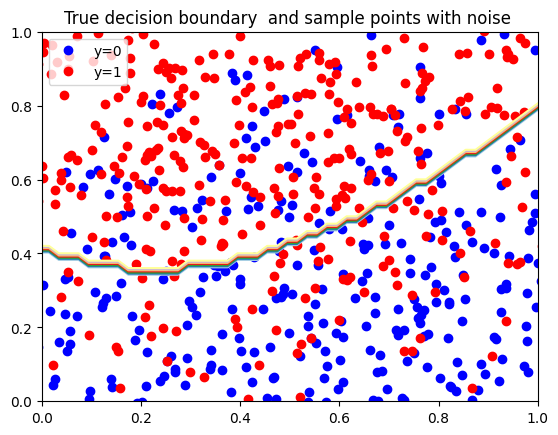

In [2]:
# Create a dataset object
data_set = Data(noise_std=0.2)
data_set.plot()

In [3]:
# Get some validation data
torch.manual_seed(0)
validation_set = Data(train=False)

In [4]:
# Create Net Class
class Net(nn.Module):

    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)

    # Prediction function
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x


# Create two model objects: model without dropout and model with dropout
model = Net(2, 300, 2)
model_drop = Net(2, 300, 2, p=0.5)



In [5]:
# Set the model to training mode
model_drop.train()

# Set optimizer functions and criterion functions
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Initialize the LOSS dictionary to store the loss
LOSS = {}
LOSS['training data no dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []



# Train the model
epochs = 500
def train_model(epochs):

    for epoch in range(epochs):
        #all the samples are used for training
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for both the training and validation data for both models
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()

train_model(epochs)

In [6]:
# Set the model to evaluation model
model_drop.eval()

# Print out the accuracy of the model without dropout
print("The accuracy of the model without dropout: ", accuracy(model, validation_set))

# Print out the accuracy of the model with dropout
print("The accuracy of the model with dropout: ", accuracy(model_drop, validation_set))


The accuracy of the model without dropout:  0.847
The accuracy of the model with dropout:  0.872


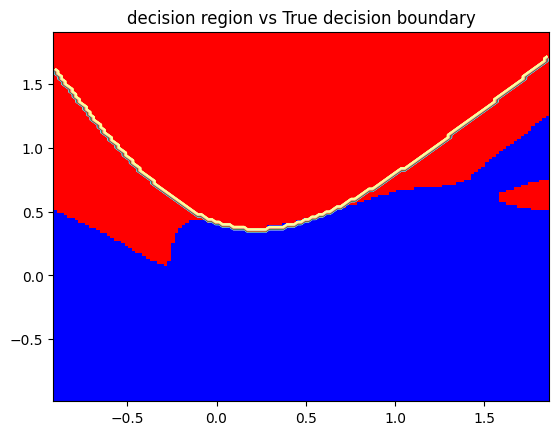

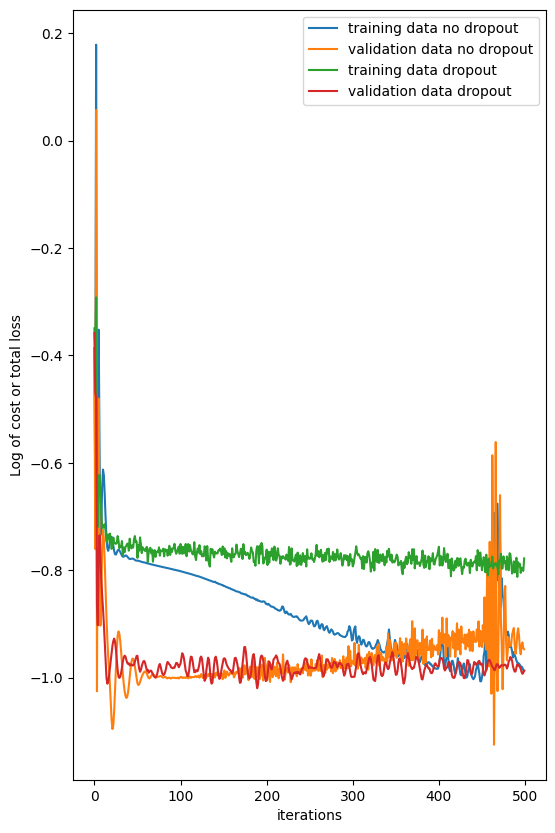

In [7]:
# Plot the decision boundary and the prediction
plot_decision_regions_3class(data_set)

# The model without dropout
plot_decision_regions_3class(data_set, model)

# The model with dropout
plot_decision_regions_3class(data_set, model_drop)

# Plot the LOSS
plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()